第十四章 递归神经网络(RNN)

一、递归神经网络基础

1、递归神经网络的数学结构

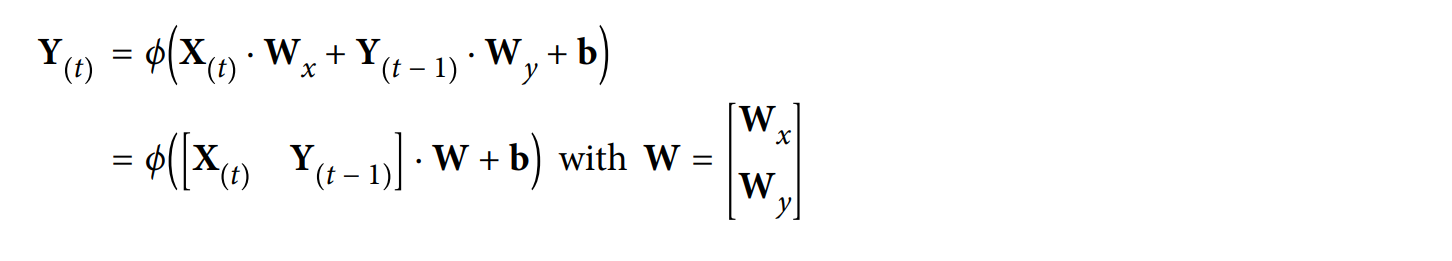

2、记忆单元

3、输入和输出序列

a、sequence-to-sequence network(如预测股票价格)

b、sequence-to-vectore network(如提供一连串关于电影评价的词汇，输出对电影的打分：-1[恨]-1[爱])

c、vector-to-sequence network(如输入图像然后输出标题)

d、sequense-to-vector network(如用于将一种语言翻译成另一种语言
sequence-to-vector:encoder[编码器]+vector-to-sequence:decoder[解码器])

4、通过时间静态展开

5、通过时间动态展开

In [1]:
import os
os.environ['OMP_NUM_THREADS']="7"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing import MinMaxScaler

In [18]:
#创建一个简单的递归神经网络（包括一个含有5个神经元的卷积层和两个时间步，三个特征）
n_inputs=3
n_neurons=5

#使用高斯函数初始化Wx的权重
Wx=tf.Variable(tf.keras.initializers.RandomNormal(mean=0.0,stddev=1.0)(shape=[n_inputs,n_neurons]),dtype=tf.float32)
#使用高斯函数初始化Wy的权重
Wy=tf.Variable(tf.keras.initializers.RandomNormal(mean=0.0,stddev=1.0)(shape=[n_neurons,n_neurons]),dtype=tf.float32)
#初始化偏置项
b=tf.Variable(tf.zeros([1,n_neurons]),detype=tf.float32)
#输入前两个时间步的数据并计算对应结果
X0=tf.constant(np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]]),dtype=tf.float32)#t=0
X1=tf.constant(np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]]),dtype=tf.float32)#t=1
Y0=tf.tanh(tf.matmul(X0,Wx)+b)
Y1=tf.tanh(tf.matmul(X1,Wx)+tf.matmul(Y0,Wy)+b)
print(Y0)
print(Y1)

tf.Tensor(
[[-0.9357871  -0.89590317 -0.99893314  0.8503579  -0.79462266]
 [-0.9945219  -1.         -0.99999475  0.9665199  -0.9998882 ]
 [-0.9995452  -1.         -1.          0.99285746 -1.        ]
 [ 1.         -0.99999857  1.         -0.9559564  -1.        ]], shape=(4, 5), dtype=float32)
tf.Tensor(
[[-0.99963015 -1.         -0.9997853   0.3864663  -1.        ]
 [-0.9837273  -0.87021655 -0.42689225 -0.744093   -0.99722314]
 [-0.99649453 -1.         -0.9647791  -0.58660203 -1.        ]
 [ 0.9716363  -0.98849607  0.4478945  -0.9172977  -0.9750258 ]], shape=(4, 5), dtype=float32)


In [44]:
#时间动态展开的示例(自动)
X=np.array([
    #t=0     t=1
    [[0,1,2],[9,8,7]],#instance0
    [[3,4,5],[0,0,0]],#instance1
    [[6,7,8],[6,5,4]],#instance2
    [[9,0,1],[3,2,1]]#instance3
            ])
X_seqs=tf.Variable(X,dtype=tf.float32)
#创建RNN单元
n_neurons=5
basic_cell=tf.keras.layers.SimpleRNNCell(n_neurons)
#用该单元创建RNN层
rnn_layer=tf.keras.layers.RNN(basic_cell,return_sequences=True)#设置参数sequences为True将返回每个时间步的输出结果
#输出结果
outputs=rnn_layer(X_seqs)#自动抽取时间序列
print(outputs)
#print()

tf.Tensor(
[[[-0.57325     0.89505064  0.62788236  0.3850208   0.8609391 ]
  [ 0.95676553 -0.99405533 -0.9984347   0.99999636  0.60120595]]

 [[-0.11329874  0.71844953  0.13725312  0.99426514  0.9789317 ]
  [ 0.35609388  0.266384   -0.5544714  -0.73071194 -0.7669157 ]]

 [[ 0.40094617  0.34706587 -0.43143845  0.9999628   0.99697095]
  [ 0.9927483  -0.9821095  -0.97558695  0.9990804  -0.10472979]]

 [[ 0.99348795 -0.9999968  -0.7920831   0.99999964 -0.88057065]
  [ 0.9697401  -0.9401309   0.4310548   0.942988    0.08285166]]], shape=(4, 2, 5), dtype=float32)


In [35]:
#时间静态展开的示例(手动)
X=np.array([
    #t=0     t=1
    [[0,1,2],[9,8,7]],#instance0
    [[3,4,5],[0,0,0]],#instance1
    [[6,7,8],[6,5,4]],#instance2
    [[9,0,1],[3,2,1]]#instance3
            ])
#创建RNN单元
n_neurons=5
basic_cell=tf.keras.layers.SimpleRNNCell(n_neurons)
#用该单元创建RNN层
rnn_layer=tf.keras.layers.RNN(basic_cell,return_sequences=True)#设置参数sequences为True将返回每个时间步的输出结果
#将输入的数据依照时间展开
input_list=tf.unstack(X,axis=1)
#初始化最初的状态
initial_state=basic_cell.get_initial_state(batch_size=X.shape[0])
#时间静态展开RNN
outputs=[]
states=[]
for input in input_list:
    input=tf.expand_dims(input,axis=1)
    output=rnn_layer(input,initial_state=initial_state)
    outputs.append(output[1:])
    states.append(output[0])
    initial_state=output[0]#更新初始状态
#将最终的结果按照时间重新堆叠
final_outputs=tf.stack(outputs,axis=1)
final_states=tf.stack(states,axis=1)
print(final_outputs)
print(final_states)

tf.Tensor(
[[[[ 0.68059486 -0.99696344 -0.9688159   0.22846732 -0.9999684 ]]

  [[-0.74112487  0.13294418 -0.2989878   0.7840402   0.15609114]]]


 [[[ 0.98544896 -0.99998116 -0.99930185 -0.31500852 -1.        ]]

  [[ 0.9959498  -0.9995847  -0.9992705  -0.6925314  -0.99997133]]]


 [[[ 0.99992055 -0.999964   -0.72704214 -0.9998816  -0.9464041 ]]

  [[ 0.90001553 -0.9354695  -0.9674309  -0.28593695 -0.9491225 ]]]], shape=(3, 2, 1, 5), dtype=float32)
tf.Tensor(
[[[-0.6626508  -0.6075702  -0.16375537  0.6591108  -0.9439722 ]
  [ 0.99984354 -0.9999975  -0.9999839  -0.88780624 -1.        ]]], shape=(1, 2, 5), dtype=float32)


In [48]:
#时间动态展开的示例(自动)
X=np.array([
    #t=0     t=1
    [[0,1,2],[9,8,7]],#instance0
    [[3,4,5],[0,0,0]],#instance1(如果例子2中只有一个时间步)
    [[6,7,8],[6,5,4]],#instance2
    [[9,0,1],[3,2,1]],#instance3
            ])
X_seqs=tf.constant(X)
#创建RNN单元
n_neurons=5
basic_cell=tf.keras.layers.SimpleRNNCell(n_neurons)
#用该单元创建RNN层
rnn_layer=tf.keras.layers.RNN(basic_cell,return_sequences=True)#设置参数sequences为True将返回每个时间步的输出结果
#设置分开的batch长度,创建一个掩码，用于指示每个序列的实际长度
seq_length_batch=[2,1,2,2]
mask=tf.sequence_mask(seq_length_batch,maxlen=X_seqs.shape[1])
#输出结果
outputs=rnn_layer(X_seqs,mask=mask)#自动抽取时间序列
print(outputs)


tf.Tensor(
[[[ 0.50526285  0.7435354   0.9088959  -0.9769031  -0.9345294 ]
  [-0.9997391   1.          0.3380532  -0.9992841  -0.548033  ]]

 [[-0.57258695  0.99979186  0.9663807  -0.99978    -0.9887612 ]
  [-0.57258695  0.99979186  0.9663807  -0.99978    -0.9887612 ]]

 [[-0.9525932   1.          0.98782533 -0.9999979  -0.99811447]
  [-0.99976534  0.99999964  0.00514708 -0.9832728   0.21605293]]

 [[-0.9999651   0.9999998  -0.99999005  0.9999544   0.9999651 ]
  [-0.9700863   0.9234912  -0.911496   -0.9284168   0.9526879 ]]], shape=(4, 2, 5), dtype=float32)


二、训练递归神经网络

1、训练方法：BPTT(backpropagation through time)

2、训练序列分类器

3、预测时间序列

In [62]:
#训练序列分类器的示例
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=x_train/255.0,x_test/255.0#将像素转换到0-1之间
basic_cell=tf.keras.layers.SimpleRNNCell(150,activation="relu")
model=tf.keras.models.Sequential([
    tf.keras.layers.RNN(basic_cell),#构建含有150个神经元的递归神经网络层
    tf.keras.layers.Dense(10,activation="sigmoid"),#连接一层深度神经网络层
])
#配置并训练模型
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
train_model=model.fit(x_train,y_train,batch_size=150,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6422 - loss: 1.0302 - val_accuracy: 0.9325 - val_loss: 0.2224
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9359 - loss: 0.2148 - val_accuracy: 0.9566 - val_loss: 0.1448
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9547 - loss: 0.1530 - val_accuracy: 0.9631 - val_loss: 0.1276
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9639 - loss: 0.1193 - val_accuracy: 0.9655 - val_loss: 0.1163
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9701 - loss: 0.1021 - val_accuracy: 0.9707 - val_loss: 0.0984
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9706 - loss: 0.0985 - val_accuracy: 0.9693 - val_loss: 0.1084
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9726 - loss: 0.0924 - val_accuracy: 0.9745 - val_loss: 0.0861
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9754 - loss: 0.0816 - val_acc

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9703 - loss: 0.1010
模型正确率为:0.9760000109672546,模型损失为:0.08341336995363235。


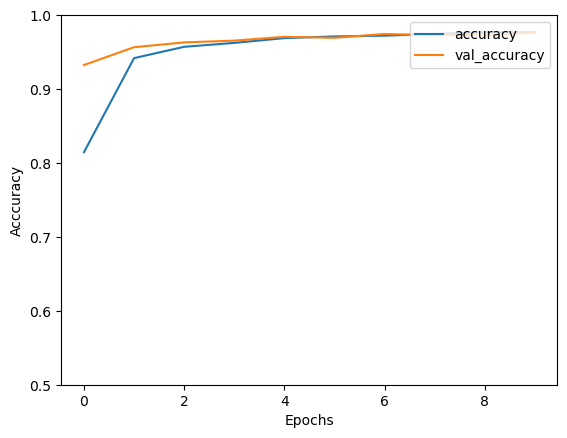

In [63]:
#可视化训练结果
loss,accuracy=model.evaluate(x_test,y_test)
print(f"模型正确率为:{accuracy},模型损失为:{loss}。")
plt.plot(train_model.history["accuracy"],label="accuracy")
plt.plot(train_model.history["val_accuracy"],label="val_accuracy")
plt.ylim([0.5,1])
plt.xlabel("Epochs")
plt.ylabel("Acccuracy")
plt.legend(loc="upper right")
plt.show()

Date
2006-01-03    40.91
2006-01-04    40.97
2006-01-05    41.53
2006-01-06    43.21
2006-01-09    43.42
              ...  
2017-12-22    71.58
2017-12-26    69.86
2017-12-27    70.06
2017-12-28    69.82
2017-12-29    69.85
Name: Close, Length: 3019, dtype: float64


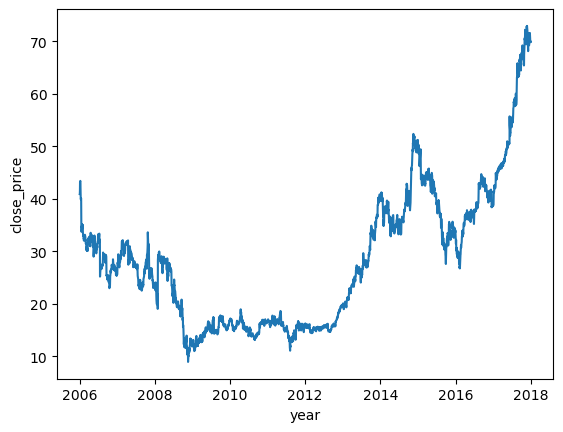

In [69]:
#训练预测时间序列的RNN神经网络
AABA=pd.read_csv(r"D:\机器学习\archive\AABA_2006-01-01_to_2018-01-01.csv",index_col="Date",parse_dates=["Date"])
AABA.head()
close_stock=AABA["Close"]
print(close_stock)
plt.plot(close_stock)
plt.xlabel("year")
plt.ylabel("close_price")
plt.show()

Date
2017-06-01    50.65
2017-06-02    50.60
2017-06-05    50.60
2017-06-06    50.50
2017-06-07    50.55
              ...  
2017-09-25    64.96
2017-09-26    64.45
2017-09-27    65.80
2017-09-28    65.58
2017-09-29    66.24
Name: Close, Length: 85, dtype: float64


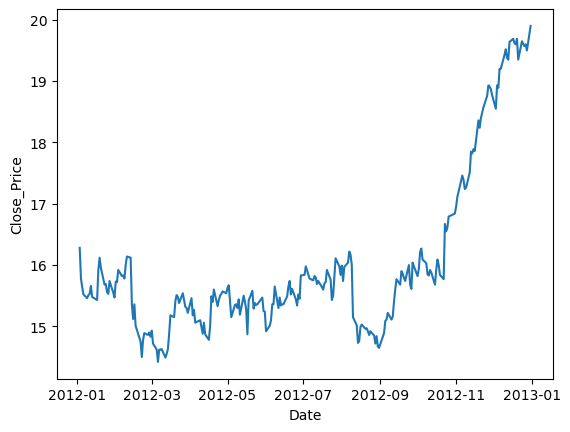

(189, 20, 1) (64, 20, 1)


In [131]:
train=close_stock.loc["2016-01":"2016-10"]
test=close_stock.loc["2017-06":"2017-09"]
print(test)
plt.plot(close_stock.loc["2012-01":"2012-12"])
plt.xlabel("Date")
plt.ylabel("Close_Price")
plt.show()
train=np.array(train).reshape(-1,1)
test=np.array(test).reshape(-1,1)
def data_processing(data,time_step):
    dataX,dataY=[],[]
    for i in range(len(data)-time_step-1):
        dataX.append(data[i:(i+time_step),0])
        dataY.append(data[(i+time_step),0])#下一个时间点作为标签
    return np.array(dataX),np.array(dataY).reshape(-1,1)
#定义时间步长
time_step=20
x_train,y_train=data_processing(train,time_step)
x_test,y_test=data_processing(test,time_step)
#将数据塑形为适合RNN的格式
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)#(例子数，时间步长，特征数)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(x_train.shape,x_test.shape)




In [132]:
#构建递归神经网络
basic_cell=tf.keras.layers.SimpleRNNCell(100,activation="relu",input_shape=(time_step,1))
model=tf.keras.models.Sequential([
    tf.keras.layers.RNN(basic_cell),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer="adam",
              loss='mean_squared_error')
train_model=model.fit(x_train,y_train,batch_size=20,epochs=20,validation_data=(x_test,y_test))

Epoch 1/20


c:\Users\youyiting\anaconda3\lib\site-packages\keras\src\layers\rnn\simple_rnn.py:103: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 1252.7046 - val_loss: 202.5240
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 55.1362 - val_loss: 1.6716
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8505 - val_loss: 30.8228
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.9809 - val_loss: 10.4298
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0793 - val_loss: 4.7736
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4640 - val_loss: 1.6857
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6855 - val_loss: 1.8921
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7176 - val_loss: 1.4501
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5065 - val_loss: 1.5466
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6429 - val_loss: 1.5613
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7286 - val_loss: 1.4735
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5716

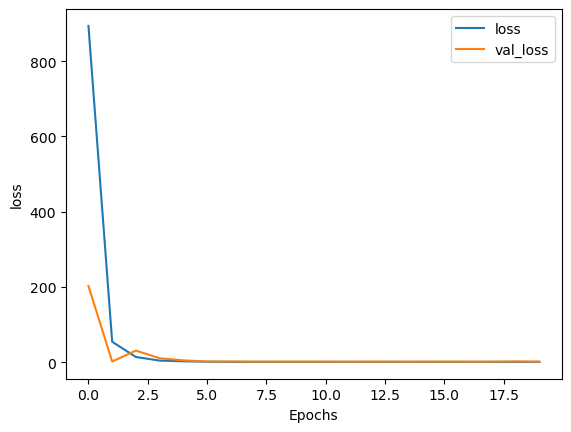

In [133]:
#可视化训练的结果
plt.plot(train_model.history["loss"],label="loss")
plt.plot(train_model.history["val_loss"],label="val_loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

In [149]:
#使用模型进行预测
y_pred=model.predict(x_test)
print(y_pred[18],y_test[18])
#最终模型实现了根据前20天的股票价格预测第21天的股票价格
history=train_model.history
for i in range(0,len(history["loss"])):
    if i%5==0:
        print(i,f"MSE:{history['loss'][i]:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[58.83834] [58.9]
0 MSE:893.98
5 MSE:1.20
10 MSE:0.64
15 MSE:0.67


In [ ]:
#推断时间序列
n_steps=20
n_inputs=1
n_neurons=100
n_outputs=1
sequence=[0.]*n_steps
basic_cell=tf.keras.layers.SimpleRNNCell(n_neurons,activation="relu",input_shape=(n_steps,1))
for iteration in range(300):#迭代300次
    X_batch=np.array(sequence[-n_steps:]).reshape(1,n_steps,1)#(一个时间序列，时间序列长度，特征数量)
    output=tf.keras.layers.RNN(basic_cell)

In [152]:
n_steps=20
sequence=[0.]*n_steps
X_batch=np.array(sequence[-n_steps:]).reshape(1,n_steps,1)#(一个时间序列，时间序列长度，特征数量)

print(X_batch)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
